<a href="https://colab.research.google.com/github/souhirbenamor/EPF/blob/main/LEAR_Easy_recalibration_Bridging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

E^{SC} and E^{EMC} and Saving Emission for single MEF time series: Charging Strategies 1 and 3

Total Emissions in Scenario 1 (E^SC - Normal Charging): 4479.75 kg CO₂
Total Emissions in Scenario 2 (E^EMC - Smart Charging): 2607.44 kg CO₂
Potential Emissions Savings: 1872.31 kg CO₂
Cumulative Emissions for E^SC (end of year): 4479.75 kg CO₂
Cumulative Emissions for E^EMC (end of year): 2607.44 kg CO₂


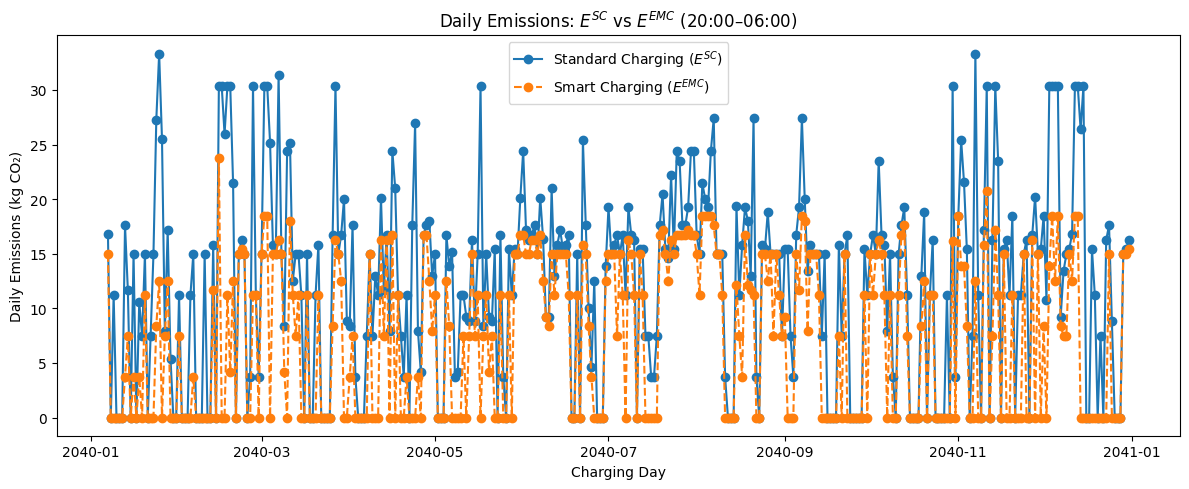

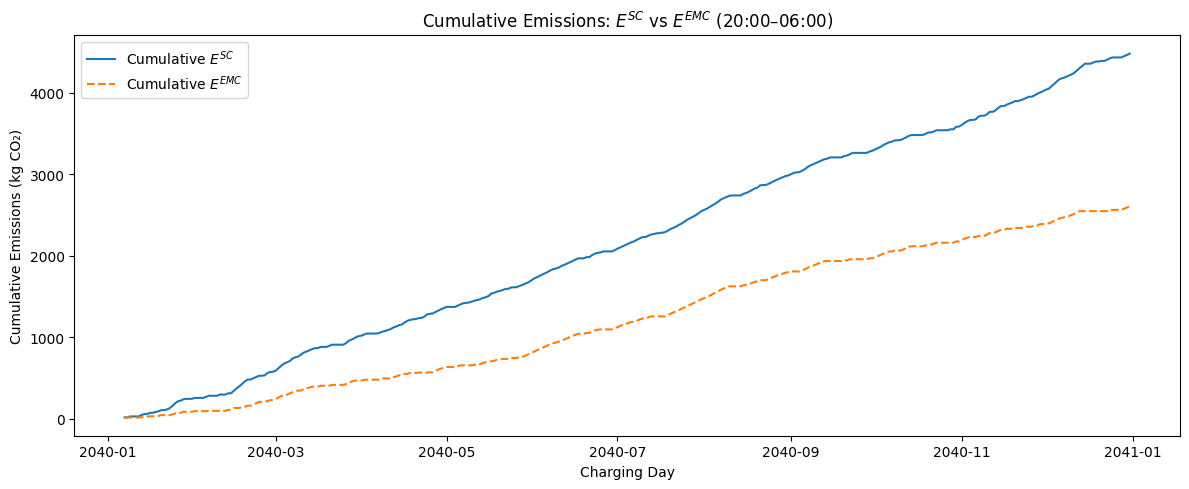

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

# Load the data from the Excel file
file_path = '/Users/vaughan/Desktop/Smart Charging/MEF--ESM/MEF_ESM_2040charging.xlsx'
df = pd.read_excel(file_path)

# Convert the 'Date' column to datetime format
df['datetime'] = pd.to_datetime(df['Date'], format='%d.%m.%Y %H:%M:%S')

# Sort the data by datetime just in case
df = df.sort_values('datetime').reset_index(drop=True)

# Extract hour and create a custom 'charging_day' column
df['hour'] = df['datetime'].dt.hour
df['charging_day'] = df['datetime'].apply(
    lambda x: x.date() if x.hour >= 6 else (x - pd.Timedelta(days=1)).date()
)

# Define constants
mef_column = 'MEF--ESM'
charging_hours = 4
charging_power_kW = 11  # Assume charging at 11 kWh per selected hour

# Function to calculate E^SC (Normal Charging: first 4 hours from 20:00 to 06:00)
def calculate_E_SC(df):
    E_SC_list = []
    for day, group in df.groupby('charging_day'):
        night_hours = group[(group['hour'] >= 20) | (group['hour'] < 6)]
        if len(night_hours) < charging_hours:
            E_SC_list.append(np.nan)
            continue
        E_SC = night_hours[mef_column].iloc[:charging_hours].sum()
        E_SC_list.append(E_SC)
    return np.array(E_SC_list)

# Function to calculate E^EMC (Smart Charging: best 4 hours from 20:00 to 06:00)
def calculate_E_EMC(df):
    E_EMC_list = []
    for day, group in df.groupby('charging_day'):
        night_hours = group[(group['hour'] >= 20) | (group['hour'] < 6)]
        if len(night_hours) < charging_hours:
            E_EMC_list.append(np.nan)
            continue
        mef_values = night_hours[mef_column].values
        combos = combinations(range(len(mef_values)), charging_hours)
        min_emissions = min(sum(mef_values[i] for i in combo) for combo in combos)
        E_EMC_list.append(min_emissions)
    return np.array(E_EMC_list)

# Run the calculations and scale for energy charged per hour (11 kWh)
E_SC = calculate_E_SC(df) * charging_power_kW
E_EMC = calculate_E_EMC(df) * charging_power_kW

# Aggregate emissions
total_E_SC = np.nansum(E_SC)
total_E_EMC = np.nansum(E_EMC)
cumulative_E_SC = np.nancumsum(E_SC)
cumulative_E_EMC = np.nancumsum(E_EMC)

# Print summary
print(f'Total Emissions in Scenario 1 (E^SC - Normal Charging): {total_E_SC:.2f} kg CO₂')
print(f'Total Emissions in Scenario 2 (E^EMC - Smart Charging): {total_E_EMC:.2f} kg CO₂')
print(f'Potential Emissions Savings: {total_E_SC - total_E_EMC:.2f} kg CO₂')
print(f'Cumulative Emissions for E^SC (end of year): {cumulative_E_SC[-1]:.2f} kg CO₂')
print(f'Cumulative Emissions for E^EMC (end of year): {cumulative_E_EMC[-1]:.2f} kg CO₂')

# Prepare x-axis
charging_days = df['charging_day'].unique()

# Plot daily emissions
plt.figure(figsize=(12, 5))
plt.plot(charging_days, E_SC, label='Standard Charging ($E^{SC}$)', marker='o')
plt.plot(charging_days, E_EMC, label='Smart Charging ($E^{EMC}$)', marker='o', linestyle='--')
plt.xlabel('Charging Day')
plt.ylabel('Daily Emissions (kg CO₂)')
plt.title('Daily Emissions: $E^{SC}$ vs $E^{EMC}$ (20:00–06:00)')
plt.legend()
plt.tight_layout()
plt.show()

# Plot cumulative emissions
plt.figure(figsize=(12, 5))
plt.plot(charging_days, cumulative_E_SC, label='Cumulative $E^{SC}$')
plt.plot(charging_days, cumulative_E_EMC, label='Cumulative $E^{EMC}$', linestyle='--')
plt.xlabel('Charging Day')
plt.ylabel('Cumulative Emissions (kg CO₂)')
plt.title('Cumulative Emissions: $E^{SC}$ vs $E^{EMC}$ (20:00–06:00)')
plt.legend()
plt.tight_layout()
plt.show()


E^{SC} and E^{EMC} and Saving Emission for combined INC-MSDR MEF time series: MEF--MSDR to define the min hours and MEF--ESM to calculate the emission: Charging Strategy 2.

Total Emissions (E^SC - Normal Charging 20:00–06:00): 4479.75 kg CO₂
Total Emissions (E^EMC - Smart Charging via MSDR 20:00–06:00): 3946.69 kg CO₂
Potential Emissions Savings: 533.06 kg CO₂


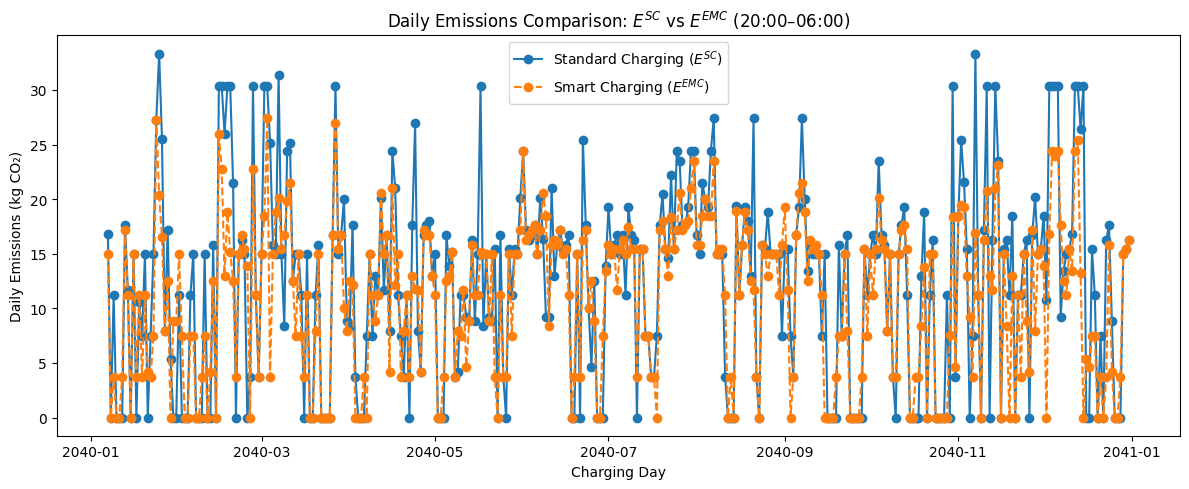

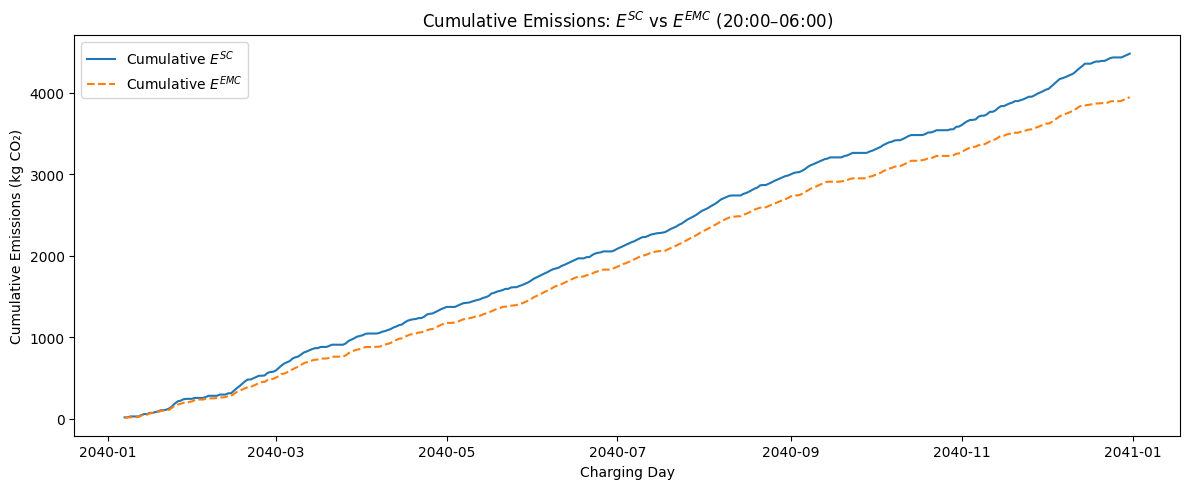

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

# Load the data
file_path = '/Users/vaughan/Desktop/Emission Minimized Charging/MEF--ESM--MSDR/MEF--ESM_and_MSDR_2040.xlsx'
df = pd.read_excel(file_path)

# Convert 'Date' to datetime and extract hour
df['datetime'] = pd.to_datetime(df['Date'], format='%d.%m.%Y %H:%M:%S')
df = df.sort_values('datetime').reset_index(drop=True)
df['hour'] = df['datetime'].dt.hour

# Create charging_day column: group 20:00–23:00 with 00:00–05:00 from next day
df['charging_day'] = df['datetime'].apply(
    lambda x: x.date() if x.hour >= 6 else (x - pd.Timedelta(days=1)).date()
)

# Charging parameters
charging_hours = 4
charging_power_kW = 11  # 11 kWh charged per selected hour
strategy_column = 'MEF--MSDR'  # used to select charging hours
actual_column = 'MEF--ESM'     # used to calculate actual emissions

# === 1. E^SC: Normal Charging (first 4 hours in 20:00–06:00 window)
def calculate_E_SC(df, mef_column):
    E_SC_list = []
    for day, group in df.groupby('charging_day'):
        night_hours = group[(group['hour'] >= 20) | (group['hour'] < 6)]
        if len(night_hours) < charging_hours:
            E_SC_list.append(np.nan)
            continue
        E_SC = night_hours[mef_column].iloc[:charging_hours].sum()
        E_SC_list.append(E_SC)
    return np.array(E_SC_list)

# === 2. E^EMC: Smart Charging (best 4 hours in 20:00–06:00 based on MSDR)
def calculate_E_EMC(df, strategy_column, actual_column):
    E_EMC_list = []
    for day, group in df.groupby('charging_day'):
        night_hours = group[(group['hour'] >= 20) | (group['hour'] < 6)]
        if len(night_hours) < charging_hours:
            E_EMC_list.append(np.nan)
            continue

        strategy_values = night_hours[strategy_column].values
        actual_values = night_hours[actual_column].values

        combos = combinations(range(len(strategy_values)), charging_hours)
        min_combo = min(combos, key=lambda combo: sum(strategy_values[i] for i in combo))
        E_EMC = sum(actual_values[i] for i in min_combo)
        E_EMC_list.append(E_EMC)
    return np.array(E_EMC_list)

# === Run calculations and scale by 11 kWh per hour
E_SC = calculate_E_SC(df, actual_column) * charging_power_kW
E_EMC = calculate_E_EMC(df, strategy_column, actual_column) * charging_power_kW

# === Aggregate and cumulative results
total_E_SC = np.nansum(E_SC)
total_E_EMC = np.nansum(E_EMC)
cumulative_E_SC = np.nancumsum(E_SC)
cumulative_E_EMC = np.nancumsum(E_EMC)

# === Output Results
print(f'Total Emissions (E^SC - Normal Charging 20:00–06:00): {total_E_SC:.2f} kg CO₂')
print(f'Total Emissions (E^EMC - Smart Charging via MSDR 20:00–06:00): {total_E_EMC:.2f} kg CO₂')
print(f'Potential Emissions Savings: {total_E_SC - total_E_EMC:.2f} kg CO₂')

# === Plot daily emissions
plt.figure(figsize=(12, 5))
plt.plot(df['charging_day'].unique(), E_SC, label='Standard Charging ($E^{SC}$)', marker='o')
plt.plot(df['charging_day'].unique(), E_EMC, label='Smart Charging ($E^{EMC}$)', linestyle='--', marker='o')
plt.xlabel('Charging Day')
plt.ylabel('Daily Emissions (kg CO₂)')
plt.title('Daily Emissions Comparison: $E^{SC}$ vs $E^{EMC}$ (20:00–06:00)')
plt.legend()
plt.tight_layout()
plt.show()

# === Plot cumulative emissions
plt.figure(figsize=(12, 5))
plt.plot(df['charging_day'].unique(), cumulative_E_SC, label='Cumulative $E^{SC}$')
plt.plot(df['charging_day'].unique(), cumulative_E_EMC, label='Cumulative $E^{EMC}$', linestyle='--')
plt.xlabel('Charging Day')
plt.ylabel('Cumulative Emissions (kg CO₂)')
plt.title('Cumulative Emissions: $E^{SC}$ vs $E^{EMC}$ (20:00–06:00)')
plt.legend()
plt.tight_layout()
plt.show()
